In [36]:
import os
import psycopg2

from astropy import units as u
from astropy.table import Table, join, unique, vstack
from astropy.coordinates import SkyCoord, match_coordinates_sky, search_around_sky

from desitarget.targets import decode_targetid, encode_targetid, resolve
from desitarget.io import releasedict, release_to_photsys

from tqdm.notebook import tqdm_notebook

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [31]:
def slowly_match_targets(pvtargtab, redux='daily', search='healpix'):
    """Match PV targets against the redshift DB for a particular spectroscopic reduction.
    
    Parameters
    ----------
    pvtargtab : astropy.Table
        Table of PV target info. Specifically need the RA, DEC, PVTYPE, and SGA_ID fields.
    redux : str
        Spectroscopic reduction: e.g., 'daily', 'everest', 'fuji', 'guadalupe', ...
    search : str
        'healpix' to search the HEALPix tables, 'tiles' to search the tiles tables.
        
    Returns
    -------
    desi_targets : astropy.Table
        Joined table of DESI redshifts and PV targets for all matches.
    """
    # Accumulate data in this table.
    desi_targets = None
        
    try:
        db = psycopg2.connect(host='decatdb.lbl.gov', database='desidb', user='desi')
        cursor = db.cursor()
        # cursor.execute('SET search_path TO da, public;')

        # Loop over all TNS alerts and perform a coordinate match with DESI observations.
        N = len(pvtargtab)
        n = 0
        with tqdm_notebook(total=N) as progress_bar:

            for i, obj in enumerate(pvtargtab):
                ra, dec = obj['RA'], obj['DEC']

                # Enable search in HEALPix tables.
                if search == 'healpix':
                    query = 'SELECT f.targetid,f.target_ra,f.target_dec,h.healpix,h.survey,r.z,r.zerr,r.zwarn,r.deltachi2,h.filename\n' \
                            f'FROM {redux}.healpix_fibermap f\n' \
                            f'INNER JOIN {redux}.healpix h ON f.healpix_id=h.id\n' \
                            f'INNER JOIN {redux}.healpix_redshifts r ON r.healpix_id=h.id AND r.targetid=f.targetid\n' \
                            f'WHERE q3c_radial_query( f.target_ra, f.target_dec, {ra}, {dec}, 1./3600. );'
                    
                    colnames = ['TARGETID', 'TARGET_RA', 'TARGET_DEC', 'HEALPIX', 'SURVEY', 'Z', 'ZERR', 'ZWARN', 'DELTACHI2', 'FILENAME']
                # Enable search in tiles tables.
                elif search == 'tiles':
                    query = 'SELECT f.targetid,f.target_ra,f.target_dec,c.tileid,c.night,r.z,r.zerr,r.zwarn,r.deltachi2,c.filename\n' \
                            f'FROM {redux}.tiles_fibermap f\n' \
                            f'INNER JOIN {redux}.cumulative_tiles c ON f.cumultile_id=c.id\n' \
                            f'INNER JOIN {redux}.tiles_redshifts r ON r.cumultile_id=c.id AND r.targetid=f.targetid\n' \
                            f'WHERE q3c_radial_query( f.target_ra, f.target_dec, {ra}, {dec}, 1./3600. );'
                    colnames = ['TARGETID', 'TARGET_RA', 'TARGET_DEC', 'TILEID', 'NIGHT', 'Z', 'ZERR', 'ZWARN', 'DELTACHI2', 'FILENAME']
                else:
                    raise ValueError(f'Search {search} not recognized; use "healpix" or "tiles."')
                    
                # TEMPORARY FOR HACKING: LIMIT TO 10 RESULTS!
                query = query.replace(');', ') LIMIT 10;')

                cursor.execute(query)
                rows = cursor.fetchall()

                if rows:
                    # Convert postgresql row output to an astropy Table.
                    data = Table(list(map(list, zip(*rows))),
                                 names=colnames)

                    # hstack the postgresql rows with the PV target info.
                    # The following vstack loop ensures every row gets a match.
                    pv_data = obj
                    if len(data) > 1:
                        for j in range(1, len(data)):
                            pv_data = vstack([pv_data, obj])
                    data = hstack([data, pv_data['PVTYPE', 'SGA_ID', 'RA', 'DEC']])

                    # Accumulate matched targets.
                    if desi_targets is None:
                        desi_targets = data
                    else:
                        desi_targets = vstack([desi_targets, data], join_type='outer')

                if (i+1) % 50 == 0:
                    progress_bar.update(50)
                    n += 50

            if n < N:
                progress_bar.update(N - n)

    except (Exception, psycopg2.Error) as error:
        print(error)
    finally:
        if db is not None:
            db.close()
            
    return desi_targets

In [2]:
def get_tf_targets(redux, use_cached=False, verbose=False):
    """Get TF targets from the DESI observations DB for a given spectroscopic reduction.
    
    Parameters
    ----------
    redux : str
        Spectroscopic reduction. E.g., 'everest', 'fuji', ...
    use_cached : bool
        Use cached data rather than re-running the query.
    
    Returns
    -------
    
    tf_targets : Table
        Table of Tully-Fisher observations.
    """
    tf_targets = None

    if os.path.exists(f'tf_targets_{redux}.fits') and use_cached:
        tf_targets = Table.read('cache/tf_targets_{redux}.fits')
    else:
        try:
            db = psycopg2.connect(host='decatdb.lbl.gov', database='desidb', user='desi')
            cursor = db.cursor()

            query = f"""SELECT rdx.targetid, rdx.target_ra, rdx.target_dec, zd.z, zd.zerr, zd.spectype, zd.deltachi2, zd.zwarn, pv.pvtype, pv.sga_id
                   FROM {redux}.healpix_fibermap as rdx, static.pv as pv, {redux}.healpix_redshifts as zd
                   WHERE q3c_join(rdx.target_ra, rdx.target_dec, pv.ra, pv.dec, 1./3600.) 
                         AND zd.targetid = rdx.targetid
                         AND rdx.targetid > 0;"""
            
            if verbose:
                print(query)

            cursor.execute(query)
            rows = cursor.fetchall()
            tf_targets = Table(list(map(list, zip(*rows))),
                               names=['TARGETID', 'TARGET_RA', 'TARGET_DEC', 'Z', 'ZERR', 'SPECTYPE', 'DELTACHI2', 'ZWARN', 'PVTYPE', 'SGA_ID'])

            #- Select only targets with SGA IDs and PV types matching SGA, EXT, and TFT
            select = (tf_targets['SGA_ID'] != None) & \
                     ((tf_targets['PVTYPE'] == 'TFT') | \
                      (tf_targets['PVTYPE'] == 'EXT') | \
                      (tf_targets['PVTYPE'] == 'SGA'))
            tf_targets = tf_targets[select]

            #- Use TARGETID to extract the photometric system used during targeting
            _, _, releases, _, _, _ = decode_targetid(tf_targets['TARGETID'].value)

            photsys = []
            for i, release in enumerate(releases):
                ps = None

                if release in releasedict:
                    ps = release_to_photsys([release])[0].decode('utf-8')
                else:
                    #- Fall-through case: not all SGA center observations are in the main survey.
                    #  In this case, select 'N' or 'S' based on the SGA object's position.
                    ra  = tf_targets['TARGET_RA'][i]
                    dec = tf_targets['TARGET_DEC'][i]
                    c = SkyCoord(ra=ra, dec=dec, unit='degree')

                    #- N: in galactic northern hemisphere and with dec > 32.375. Else, S.
                    isnorth = (c.galactic.b > 0) & (dec > 32.375)
                    ps = 'N' if isnorth else 'S'

                photsys.append(ps)

            #- Complain if the photsys table doesn't match the size of the Vrot table.
            if len(photsys) != len(tf_targets):
                print(f'photsys array of len {len(photsys)} != targets array of len {len(tf_targets)}')

            tf_targets['PHOTSYS'] = photsys

            # tf_targets.write(f'cache/tf_targets_{redux}.fits', overwrite=True)

        except Exception as error:
            print(error)
        finally:
            if db is not None:
                db.close()

    return tf_targets

In [3]:
def plot_radec_DESI(table, verbose=False):
    """Mollweide projection plot adapted to astro coordinates.
    
    Parameters
    ----------
    table : astropy.table.Table
        Data table with secondary target info
        
    Returns
    -------
    fig : matplotlib.Figure
        Figure object to let user apply further plot manipulation
    """
    if verbose:
        print(len(table))
    
    fig, ax = plt.subplots(1,1, 
                           figsize=(8,4), 
                           subplot_kw={'projection':'mollweide'})
    
    #- Loop through unique classes
    class_names = np.unique(table['PVTYPE'])
    for class_name in class_names:
        select = table['PVTYPE'] == class_name
        
        #- Convert ra,dec to radians
        #- Rotate the ra so that the plot goes 360->0 left to right
        ra_name = 'TARGET_RA' if 'TARGET_RA' in table.colnames else 'RA'
        dec_name = 'TARGET_DEC' if 'TARGET_DEC' in table.colnames else 'DEC'
        
        _ra = np.radians(180. - table[ra_name][select])
        _dec = np.radians(table[dec_name][select])
        
        ax.scatter(_ra, _dec, alpha=0.5, s=5, label=class_name)    
    
    ax.set(xticks=np.radians([-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150]), 
           xticklabels=['22h', '20h', '18h', '16h', '14h', '12h', '10h', '8h', '6h', '4h', '2h'])
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(ls=':')
    
    ax.legend(fontsize=8, loc='lower right')
    fig.tight_layout()
    
    return fig

## TF Targeting Tables

These are the targeting FITS files from Khaled.

In [6]:
#- Access PV targeting table from the DESI database.
db = psycopg2.connect(host='decatdb.lbl.gov', database='desidb', user='desi')
cursor = db.cursor()

query = "SELECT * FROM static.pv WHERE pvtype LIKE 'TFT';"
cursor.execute(query)
rows = cursor.fetchall()
# pv_tf_db = Table(list(map(list, zip(*rows))),
#                  names=['OBJID', 'BRICKID', 'BRICKNAME', 'RA', 'DEC', 'PMRA', 'PMDEC', 'REF_EPOCH', 'OVERRIDE', 'PVTYPE', 'PVPRIORITY', 'POINTINGID', 'SGA_ID'],
#                  dtype=[np.int64, np.int32, str, np.float64, np.float64, np.float32, np.float32, bool, str, np.int32, np.int64, np.int64])
db.close()

In [7]:
pv_tf_db = Table(list(map(list, zip(*rows))),
                 names=['OBJID', 'BRICKID', 'BRICKNAME', 'RA', 'DEC', 'PMRA', 'PMDEC', 'REF_EPOCH', 'OVERRIDE', 'PVTYPE', 'PVPRIORITY', 'POINTINGID', 'SGA_ID'])
                 #dtype=[np.int64, np.int32, str, np.float64, np.float64, np.float32, np.float32, np.float32, bool, str, np.int32, np.int64, np.int64])

In [4]:
pv_tf  = Table.read('/global/cfs/cdirs/desi/science/td/pv/desi_pv/savepath_dr9_corr/pv_tf.fits')
pv_fp  = Table.read('/global/cfs/cdirs/desi/science/td/pv/desi_pv/savepath_dr9_corr/pv_fp.fits')
pv_sga = Table.read('/global/cfs/cdirs/desi/science/td/pv/desi_pv/savepath_dr9_corr/pv_sga.fits')
pv_ext = Table.read('/global/cfs/cdirs/desi/science/td/pv/desi_pv/savepath_dr9_corr/pv_ext.fits')

len(pv_tf), len(pv_sga), len(pv_ext), len(pv_tf) + len(pv_sga) + len(pv_ext)

(389316, 81611, 20486, 491413)

In [9]:
pv_tf['BRICKNAME'] = pv_tf['BRICKNAME'].astype(str)
pv_tf['PVTYPE'] = pv_tf['PVTYPE'].astype(str)
pv_tf.remove_column('SGA_ID')
pv_tf[:5]

OBJID,BRICKID,BRICKNAME,RA,DEC,PMRA,PMDEC,REF_EPOCH,OVERRIDE,PVTYPE,PVPRIORITY,POINTINGID
int64,int32,str8,float64,float64,float32,float32,float32,bool,str3,int32,int64
262,520796,2267p350,226.62204270638287,34.98227660676318,0.0,0.0,2015.5,True,TFT,1,1
262,520796,2267p350,226.62323955692426,34.98099178744529,0.0,0.0,2015.5,False,TFT,2,2
262,520796,2267p350,226.62443636990747,34.97970695638398,0.0,0.0,2015.5,True,TFT,1,3
2738,514840,2263p337,226.40142777879575,33.68537046528162,0.0,0.0,2015.5,True,TFT,1,1
2738,514840,2263p337,226.40426477759235,33.68450278837041,0.0,0.0,2015.5,False,TFT,2,2


In [10]:
pv_tf_db['BRICKID'] = pv_tf_db['BRICKID'].astype(np.int32)
pv_tf_db['PMRA'] = pv_tf_db['PMRA'].astype(np.float32)
pv_tf_db['PMDEC'] = pv_tf_db['PMDEC'].astype(np.float32)
pv_tf_db['REF_EPOCH'] = pv_tf_db['REF_EPOCH'].astype(np.float32)
pv_tf_db['PVPRIORITY'] = pv_tf_db['PVPRIORITY'].astype(np.int32)
# pv_tf_db['SGA_ID'] = pv_tf_db['SGA_ID'].astype(np.int64)
pv_tf_db.remove_column('SGA_ID')

pv_tf_db[:5]

OBJID,BRICKID,BRICKNAME,RA,DEC,PMRA,PMDEC,REF_EPOCH,OVERRIDE,PVTYPE,PVPRIORITY,POINTINGID
int64,int32,str8,float64,float64,float32,float32,float32,bool,str3,int32,int64
262,520796,2267p350,226.62204270638287,34.98227660676318,0.0,0.0,2015.5,True,TFT,1,1
262,520796,2267p350,226.62323955692426,34.98099178744529,0.0,0.0,2015.5,False,TFT,2,2
262,520796,2267p350,226.62443636990747,34.97970695638398,0.0,0.0,2015.5,True,TFT,1,3
2738,514840,2263p337,226.40142777879575,33.68537046528162,0.0,0.0,2015.5,True,TFT,1,1
2738,514840,2263p337,226.40426477759235,33.68450278837041,0.0,0.0,2015.5,False,TFT,2,2


In [11]:
pv_tf_dbonly = unique(vstack([pv_tf, pv_tf_db]), keep='none')
pv_tf_dbonly

OBJID,BRICKID,BRICKNAME,RA,DEC,PMRA,PMDEC,REF_EPOCH,OVERRIDE,PVTYPE,PVPRIORITY,POINTINGID
int64,int32,str8,float64,float64,float32,float32,float32,bool,str3,int32,int64
2,246282,3575m150,357.40876261957146,-14.904599907700625,0.0,0.0,2015.5,True,TFT,1,1
2,246282,3575m150,357.4107730136317,-14.904945960960998,0.0,0.0,2015.5,True,TFT,1,2
2,246282,3575m150,357.41284433548464,-14.905302482344975,0.0,0.0,2015.5,True,TFT,1,3
2,246282,3575m150,357.41485474266807,-14.905648500005944,0.0,0.0,2015.5,False,TFT,2,4
2,246282,3575m150,357.41686515631494,-14.905994500132145,0.0,0.0,2015.5,True,TFT,1,5
2,246282,3575m150,357.41893649834753,-14.9063509667703,0.0,0.0,2015.5,True,TFT,1,6
2,246282,3575m150,357.42094692511665,-14.906696931294128,0.0,0.0,2015.5,True,TFT,1,7
6,504362,0001p317,0.00046596813492376783,31.73156696622248,0.0,0.0,2015.5,False,TFT,2,4
6,504362,0001p317,0.0011077302503429483,31.729742602303062,0.0,0.0,2015.5,True,TFT,1,5


389316


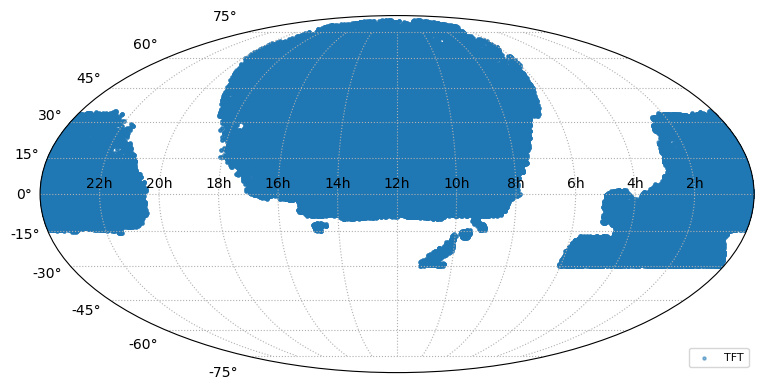

In [12]:
fig = plot_radec_DESI(pv_tf, verbose=True)

1285358


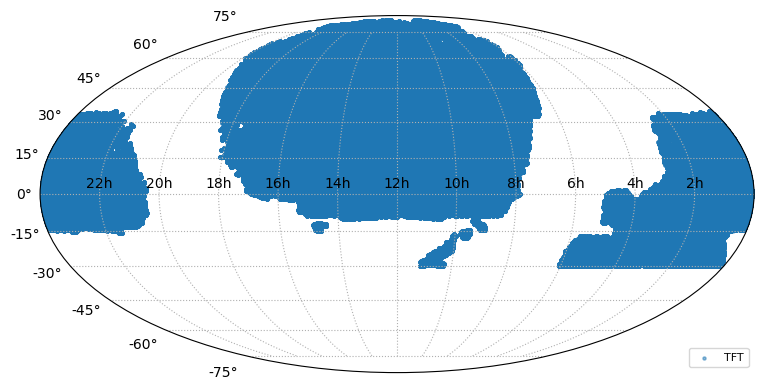

In [13]:
fig = plot_radec_DESI(pv_tf_db, verbose=True)

896042


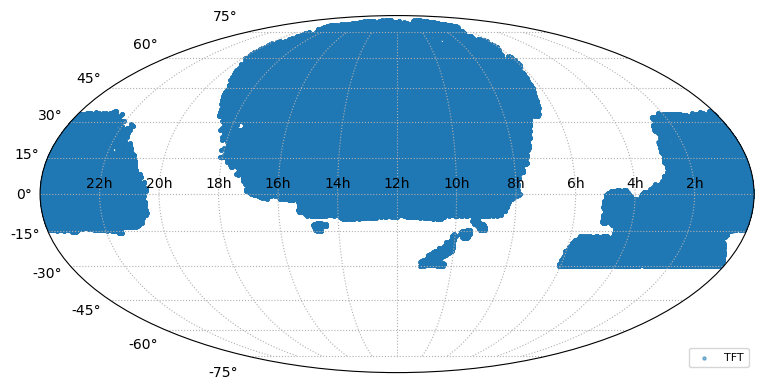

In [14]:
fig = plot_radec_DESI(pv_tf_dbonly, verbose=True)

## Stupid Test of a Stupid Thing

See if we can read the **entire** fuji healpix fibermap and do an angular cone search against Khaled's PV TF list.

In [115]:
db = psycopg2.connect(host='decatdb.lbl.gov', database='desidb', user='desi')
cursor = db.cursor()

query = f"""SELECT f.targetid, f.target_ra, f.target_dec, f.ref_epoch, h.healpix, h.survey, h.program FROM fuji.healpix_fibermap f
                    INNER JOIN fuji.healpix h on f.healpix_id = h.id
                    WHERE f.targetid > 0;
       """

# query = f"""SELECT f.targetid, r.targetid, f.target_ra, f.target_dec, f.ref_epoch, r.z FROM fuji.healpix_fibermap f
#                    INNER JOIN fuji.healpix_redshifts r ON r.targetid=f.targetid
#                    WHERE f.targetid > 0;
#        """

# query = f"""SELECT f.targetid, r.targetid, f.target_ra, f.target_dec, f.ref_epoch, r.z
#                    FROM fuji.healpix_fibermap f, fuji.healpix_redshifts r
#                    WHERE r.targetid = f.targetid AND f.targetid > 0;
#         """

cursor.execute(query)
rows = cursor.fetchall()
fuji_hpx = Table(list(map(list, zip(*rows))),
                    names=['TARGETID', 'TARGET_RA', 'TARGET_DEC', 'REF_EPOCH', 'HEALPIX', 'SURVEY', 'PROGRAM'])
                    # names=['TARGETID', 'Z_TARGETID', 'TARGET_RA', 'TARGET_DEC', 'REF_EPOCH', 'Z'])

db.close()

In [118]:
ids, cts = np.unique(fuji_hpx['TARGETID'], return_counts=True)
select = np.in1d(fuji_hpx['TARGETID'], ids[cts == 5])
selected = fuji_hpx[select]
selected.sort('TARGETID')
selected

TARGETID,TARGET_RA,TARGET_DEC,REF_EPOCH,HEALPIX,SURVEY,PROGRAM
int64,float64,float64,float64,int64,str7,str6
39627823471663007,149.49903383859635,1.5781950445603563,2015.5,27247,sv3,bright
39627823471663007,149.499027927487,1.5781891758585005,2021.0882568359375,27247,sv1,bright
39627823471663007,149.49902782884033,1.5781890500926707,2021.2005615234375,27247,sv1,other
39627823471663007,149.49903383859635,1.5781950445603563,2015.5,27247,sv3,dark
39627823471663007,149.49902808150503,1.5781893144748607,2020.94873046875,27247,sv1,dark
39627823484243615,150.1832583004434,1.4710928427269834,2021.0882568359375,27256,sv1,bright
39627823484243615,150.18325839476975,1.47109274837369,2020.94873046875,27256,sv1,dark
39627823484243615,150.18326226487892,1.4710888472598835,2015.5,27256,sv3,bright
39627823484243615,150.18325820709606,1.4710929283367076,2021.2005615234375,27256,sv1,other


In [117]:
np.unique(cts)

array([1, 2, 3, 4, 5])

In [91]:
print(len(fuji_hpx))
fuji_hpx[:10]

2637487


TARGETID,Z_TARGETID,TARGET_RA,TARGET_DEC,REF_EPOCH,Z
int64,int64,float64,float64,float64,float64
6432023904256,6432023904256,179.44416,27.6589,2021.18408203125,-0.0019956912923479522
6448025174016,6448025174016,179.15657,28.4234799,2021.18408203125,0.022190569941649994
6515536691200,6515536691200,142.94811,31.82478,2021.2032470703125,0.5364068034833155
6521555517440,6521555517440,204.22749,32.09493,2021.2032470703125,0.010017642879535897
6536638234624,6536638234624,186.274119,32.84503,2021.2032470703125,0.07641158065394126
6546033475584,6546033475584,132.66211,33.16773,2021.104736328125,1.0408032337323003
28684312379395,28684312379395,9.145797407753296,41.019015274818415,2021.0252685546875,-0.0005149712963655131
28684312379396,28684312379396,9.000947407753296,40.938848574818415,2021.0252685546875,0.18835998178379842
28684316573697,28684316573697,9.396959907753297,40.96454027481841,2021.0252685546875,0.08079590364163276


In [85]:
np.any(fuji_hpx['TARGETID'] != fuji_hpx['Z_TARGETID'])

False

In [30]:
ep, ct = np.unique(fuji_hpx['REF_EPOCH'], return_counts=True)
for e, c in zip(ep, ct):
    print(e, c)

0.0 803077
1999.2159423828125 1
1999.218017578125 4
2000.0 12024
2000.259033203125 2
2000.3380126953125 1
2000.3409423828125 1
2001.137939453125 2
2001.2110595703125 2
2001.2850341796875 1
2001.2879638671875 3
2001.373046875 1
2001.3890380859375 1
2001.718017578125 1
2002.3480224609375 2
2002.43505859375 3
2003.31396484375 1
2003.47802734375 3
2004.3900146484375 2
2004.970947265625 1
2005.0469970703125 1
2013.8876953125 1
2013.961669921875 1
2014.03564453125 1
2014.194580078125 1
2014.4986572265625 1
2014.5343017578125 1
2014.5889892578125 1
2014.6246337890625 1
2014.6767578125 1
2014.7342529296875 1
2014.7835693359375 1
2015.0438232421875 1
2015.046630859375 1
2015.0657958984375 1
2015.1807861328125 1
2015.43017578125 1
2015.5 1350305
2015.531494140625 1
2015.6739501953125 1
2015.8438720703125 1
2015.8712158203125 1
2015.8848876953125 1
2015.898681640625 1
2015.9918212890625 1
2016.125732421875 1
2016.1776123046875 1
2016.2486572265625 1
2016.30322265625 1
2016.33056640625 1
2016.4016

In [11]:
fuji_coords = SkyCoord(ra=fuji_hpx['TARGET_RA'], dec=fuji_hpx['TARGET_DEC'], unit='deg')
pv_tf_coords = SkyCoord(ra=pv_tf['RA'], dec=pv_tf['DEC'], unit='deg')

In [40]:
i, d2d, d3d = match_coordinates_sky(pv_tf_coords, fuji_coords)
len(d2d), np.sum(d2d < 1*u.arcsec)

(389316, 3434)

In [52]:
# i, d2d, d3d = match_coordinates_sky(pv_tf_coords, fuji_coords)
i, j, d2d, d3d = search_around_sky(pv_tf_coords, fuji_coords, (1./3600.)*u.deg)

In [53]:
len(d2d)

3605

In [55]:
fuji_hpx[j]

TARGETID,TARGET_RA,TARGET_DEC,REF_EPOCH
int64,float64,float64,float64
39633244064320316,171.81657940550176,49.82847914759144,2015.5
39633244072707261,172.39942879569637,49.862492954612335,2015.5
39633247985992523,172.73576337119005,49.980207719691805,2015.5
39633236204191887,172.76833663150416,49.29326567877447,2015.5
39633247981799047,172.4455422072212,49.919688430554814,2015.5
39633236208388579,173.37046669173367,49.239132293014706,2015.5
39633236208389728,173.48451642845188,49.33160040945008,2015.5
39633236212581593,173.64809639956394,49.22250743675216,2015.5
39633236212582005,173.702734361046,49.2417345677238,2015.5


## Desperation Test of Old Matches

Run the old, slow matching of coordinates against the fuji tables, see what happens.

In [35]:
pv_tf_fuji = slowly_match_targets(pv_tf, redux='fuji')

  0%|          | 0/389316 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
pv_tf_fuji

## Tully-Fisher Targets

### Reduction: Fuji

In [15]:
tf_fuji = get_tf_targets('fuji', verbose=True)
tf_fuji

SELECT rdx.targetid, rdx.target_ra, rdx.target_dec, zd.z, zd.zerr, zd.spectype, zd.deltachi2, zd.zwarn, pv.pvtype, pv.sga_id
                   FROM fuji.healpix_fibermap as rdx, static.pv as pv, fuji.healpix_redshifts as zd
                   WHERE q3c_join(rdx.target_ra, rdx.target_dec, pv.ra, pv.dec, 1./3600.) 
                         AND zd.targetid = rdx.targetid
                         AND rdx.targetid > 0;


TARGETID,TARGET_RA,TARGET_DEC,Z,ZERR,SPECTYPE,DELTACHI2,ZWARN,PVTYPE,SGA_ID,PHOTSYS
int64,float64,float64,float64,float64,str6,float64,int64,str3,object,str1
67855194259463,130.28639041727004,20.89577379903803,0.014858176734274708,8.236207966674088e-06,GALAXY,235.80787120154127,0,TFT,867551,S
234526940856326,151.1772061023157,1.833743864948717,0.031084094388153436,1.2803928008463756e-06,GALAXY,12466.349258303642,0,TFT,5001181,S
243323033878537,151.1772061023157,1.833743864948717,0.031083767297092765,1.2521524876650265e-06,GALAXY,13217.184797286987,0,TFT,5001181,S
1009771901616128,192.16658685134746,62.6175481394664,0.10559346795182166,9.905922104515246e-06,GALAXY,66280.81822794676,0,SGA,995236,N
1009780189560832,189.24419316133017,63.18724541366517,0.300599369174926,3.595918823885058e-05,GALAXY,4571.731836244464,0,SGA,1171917,N
1070072319705092,216.65967443865358,-1.6446315711526935,0.05696858418177025,3.6661286162886536e-06,GALAXY,2280.5004700422287,0,TFT,812997,S
1070072319705093,216.6612587958119,-1.6427216960418378,0.05622034664725269,3.857130278712472e-06,GALAXY,1409.0118267536163,0,TFT,812997,S
1070078338531330,215.28301066827586,-1.3914584159002852,0.054563054688667366,4.788320584630243e-06,GALAXY,1034.0474154353142,0,TFT,288715,S
1070078338531331,215.2842612059831,-1.3933991206726468,0.055457840740994135,3.910389608538057e-06,GALAXY,1771.7217105925083,0,TFT,288715,S


In [ ]:
isgoodz = (tf_fuji['DELTACHI2'] >= 25) & (tf_fuji['ZWARN'] == 0)
# isgoodz = tf_coma_targets['ZWARN'] == 0

# tf_fuji = tf_fuji[isgoodz]
np.sum(isgoodz)

In [ ]:
len(np.unique(tf_fuji['TARGETID'][isgoodz]))

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,5), tight_layout=True)

zdata = []
pvtypes = np.unique(tf_fuji['PVTYPE'][isgoodz])

for pvtype in pvtypes:    
    ispvtype = tf_fuji['PVTYPE'][isgoodz] == pvtype
    zdata.append(list(tf_fuji['Z'][isgoodz][ispvtype]))
zbins = np.linspace(0,0.3, 16)

ax.hist(zdata, bins=zbins, stacked=True, log=True, label=pvtypes)
ax.set(#ylim=(0,15), 
       xlabel='redshift', 
       ylabel='count')
ax.grid(ls=':')

ax.legend(fontsize=12);

In [ ]:
fig = plot_radec_DESI(tf_fuji[isgoodz])

In [26]:
tf_fuji_std = Table.read('/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/desi_pv_tf_fuji_healpix.fits')
tf_fuji_std

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC
int64,float64,float64,int64,bytes3,float64,float64,int64,float64,bytes63,bytes3,int64,float64,float64
1079550234591232,194.390863195343,27.5157211790145,10378,sv3,1.1235686466514,7.31685779475115e-05,4,3.28414569795132,fuji/healpix/sv3/bright/103/10378/redrock-sv3-bright-10378.fits,EXT,662902,194.39086319534337,27.51572117901454
1092744374124544,194.390863195343,27.5157211790145,10378,sv3,0.686773088332363,6.9756676262104e-05,4,0.786607094109058,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.39086319534337,27.51572117901454
1092744374124546,194.364461113654,27.5037185881314,10378,sv3,0.0242933923052181,4.95233472646785e-05,0,95.428411073226,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.36446111365385,27.50371858813136
1092744369930240,194.338458724402,27.4918902690326,10378,sv3,0.0264170223697961,0.00010139452689994,0,9.53278421035066,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.33845872440244,27.491890269032595
1092744374124545,194.377858465028,27.5098100780282,10378,sv3,0.211332646769145,6.68535116703737e-05,4,3.73989077657461,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.3778584650283,27.509810078028195
1092744369930241,194.325065734878,27.4857950068364,10378,sv3,0.34112572843082,7.87536530522298e-05,4,5.80425057094544,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.3250657348779,27.48579500683636
1079550230396930,194.312068074608,27.4798777913963,10378,sv3,1.43883246626074,0.000118079246392633,4,1.41281921416521,fuji/healpix/sv3/bright/103/10378/redrock-sv3-bright-10378.fits,EXT,662902,194.3120680746076,27.479877791396284
1092744369930242,194.312068074608,27.4798777913963,10378,sv3,0.141836800089955,6.14844128636576e-05,4,8.01571118086576,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.3120680746076,27.479877791396284
1080141245579266,268.972484124775,62.5902888954075,10207,sv3,1.25885927887654,0.000161730072763419,4,4.86104696989059,fuji/healpix/sv3/bright/102/10207/redrock-sv3-bright-10207.fits,EXT,674212,268.972484124775,62.59028889540747


In [37]:
isgoodz = (tf_fuji_std['DELTACHI2'] >= 25) & (tf_fuji_std['ZWARN'] == 0)
# isgoodz = tf_coma_targets['ZWARN'] == 0

# tf_fuji = tf_fuji[isgoodz]
np.sum(isgoodz)

7316

In [39]:
len(np.unique(tf_fuji_std['TARGETID'][isgoodz]))

7200

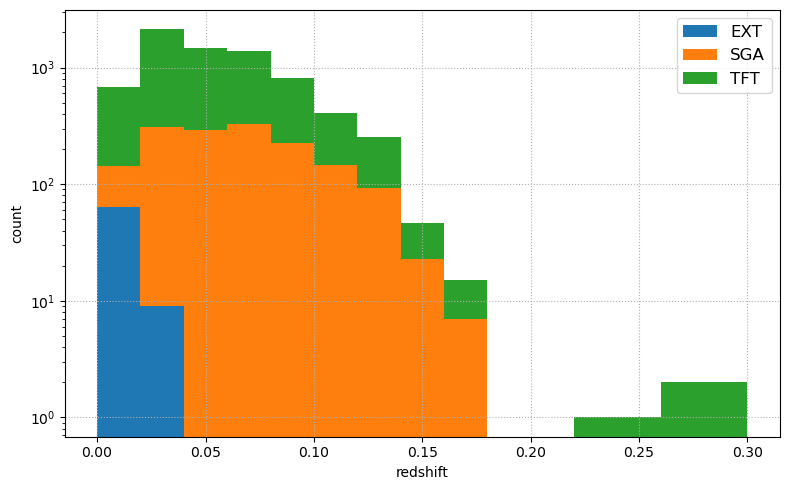

In [30]:
fig, ax = plt.subplots(1,1, figsize=(8,5), tight_layout=True)

zdata = []
pvtypes = np.unique(tf_fuji_std['PVTYPE'][isgoodz])

for pvtype in pvtypes:    
    ispvtype = tf_fuji_std['PVTYPE'][isgoodz] == pvtype
    zdata.append(list(tf_fuji_std['Z'][isgoodz][ispvtype]))
zbins = np.linspace(0,0.3, 16)

ax.hist(zdata, bins=zbins, stacked=True, log=True, label=pvtypes)
ax.set(#ylim=(0,15), 
       xlabel='redshift', 
       ylabel='count')
ax.grid(ls=':')

ax.legend(fontsize=12);

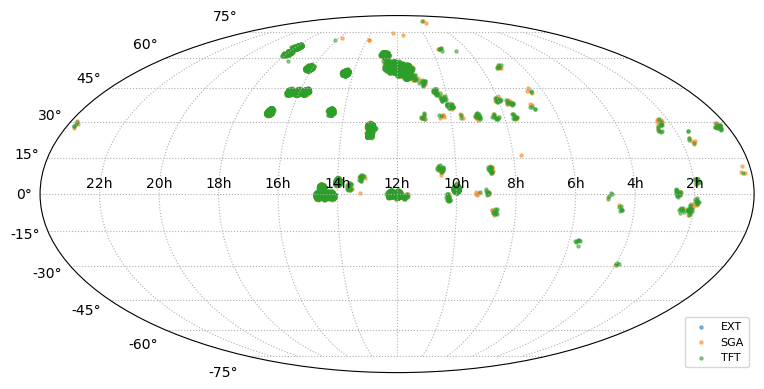

In [32]:
fig = plot_radec_DESI(tf_fuji_std[isgoodz])

### Reduction: Iron

In [8]:
tf_iron = get_tf_targets('iron')
tf_iron

TARGETID,TARGET_RA,TARGET_DEC,Z,ZERR,SPECTYPE,DELTACHI2,ZWARN,PVTYPE,SGA_ID,PHOTSYS
int64,float64,float64,float64,float64,str6,float64,int64,str3,object,str1
46529817608200,262.7290855,56.8275909,0.0300701053304558,1.684425405947947e-06,GALAXY,8720.633041620255,0,TFT,1026585,N
46529817608200,262.7290855,56.8275909,0.0300701053304558,1.684425405947947e-06,GALAXY,8720.633041620255,0,TFT,1026585,N
67798239805447,130.17724131447162,18.61365755140834,0.932752477574551,2.232146096148817e-46,GALAXY,0.0,518,TFT,1002244,S
67815440646152,131.54147036553024,19.348963933595506,0.6884018876561712,0.00047972305455262656,QSO,5.827984752831981,4,TFT,993764,S
67849540337671,130.29743013366775,20.750793362030286,0.05220319852209492,1.6019826652420617e-06,GALAXY,15049.715398669243,0,TFT,1023610,S
67855194259463,130.28639041727004,20.89577379903803,0.0148578654666593,8.267973017299846e-06,GALAXY,245.5905209388584,0,TFT,867551,S
234526940856326,151.1772061023157,1.833743864948717,0.03108423883590361,1.2810993039280171e-06,GALAXY,12411.190822601318,0,TFT,5001181,S
243323033878537,151.1772061023157,1.833743864948717,0.031083475508907214,1.2420802775973914e-06,GALAXY,12847.326836943626,0,TFT,5001181,S
1004815400304641,193.6701,28.93758,0.00827270804239493,1.688822413779953e-06,GALAXY,20777.348798625462,0,TFT,188925,S


In [9]:
isgoodz = (tf_iron['DELTACHI2'] >= 25) & (tf_iron['ZWARN'] == 0)
# isgoodz = tf_coma_targets['ZWARN'] == 0

# tf_everest = tf_everest[isgoodz]
np.sum(isgoodz)

102014

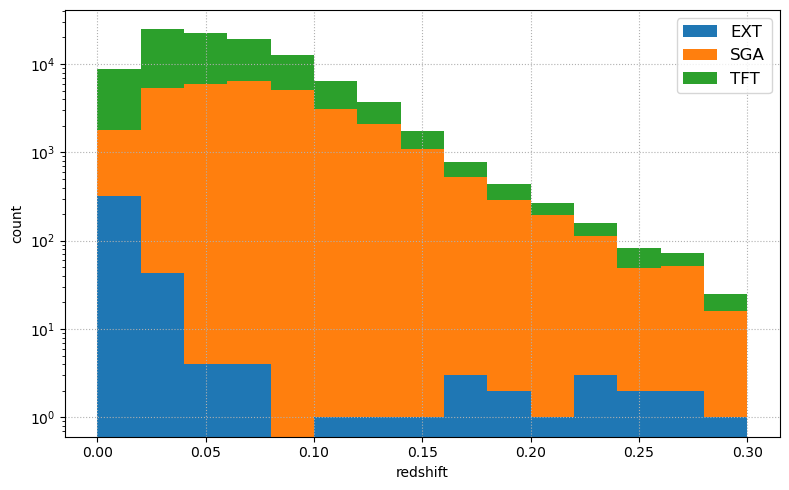

In [10]:
fig, ax = plt.subplots(1,1, figsize=(8,5), tight_layout=True)

zdata = []
pvtypes = np.unique(tf_iron['PVTYPE'][isgoodz])

for pvtype in pvtypes:    
    ispvtype = tf_iron['PVTYPE'][isgoodz] == pvtype
    zdata.append(list(tf_iron['Z'][isgoodz][ispvtype]))
zbins = np.linspace(0,0.3, 16)

ax.hist(zdata, bins=zbins, stacked=True, log=True, label=pvtypes)
ax.set(#ylim=(0,15), 
       xlabel='redshift', 
       ylabel='count')
ax.grid(ls=':')

ax.legend(fontsize=12);

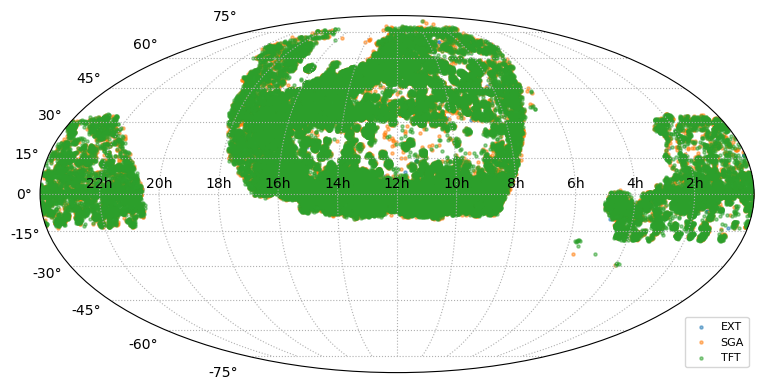

In [11]:
fig = plot_radec_DESI(tf_iron[isgoodz])